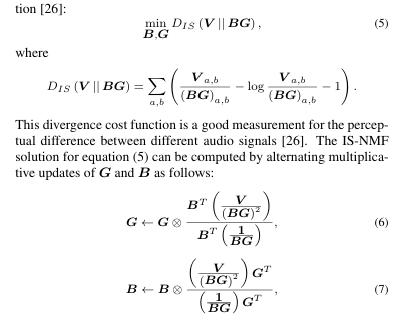

In [643]:
import math
import numpy as np
import librosa
import sounddevice as sd
import matplotlib.pyplot as plt

sample_rate=48000
music_ratio=50
hop_length=512
n_fft=2048

In [661]:
def cost_function(mat_V, mat_B, mat_G):
    #IS divergence cost function
    cost=mat_V/np.dot(mat_B, mat_G)-np.log(mat_V/np.dot(mat_B, mat_G))-np.ones((mat_V.shape[0], mat_V.shape[1]))
    cost=cost.sum()
    return cost

def NMF(mat_V, latent_component, epoch, cost_function):
    row=mat_V.shape[0]
    col=mat_V.shape[1]
    r=latent_component

    #초기값 설정
    mat_B=np.random.random((row, r))
    mat_G=np.random.random((r, col))

    #update
    cost=cost_function(mat_V, mat_B, mat_G)
    for i in range(epoch):
        temp_G=mat_G* (np.dot(mat_B.T, mat_V / (np.dot(mat_B, mat_G)**2)) / np.dot(mat_B.T, np.ones((mat_V.shape[0], mat_V.shape[1]))/ np.dot(mat_B, mat_G)))
        temp_B=mat_B* (np.dot((mat_V / (np.dot(mat_B, mat_G)**2)), mat_G.T)) / np.dot((np.ones((mat_V.shape[0], mat_V.shape[1])) / np.dot(mat_B, mat_G)), mat_G.T)
        temp_cost=cost_function(mat_V, temp_B, temp_G)
        if temp_cost<cost:
            mat_B=temp_B
            mat_G=temp_G
            cost=temp_cost

    return mat_V, mat_B, mat_G, cost

def NMF_test(mat_V, mat_B1, mat_B2, latent_component, epoch, cost_function):
    row=mat_V.shape[0]
    col=mat_V.shape[1]
    r=latent_component

    #초기값 설정
    mat_G1=np.random.random((r, col))
    mat_G2=np.random.random((r, col))

    #update
    cost=cost_function(mat_V, mat_B1, mat_G1)+cost_function(mat_V, mat_B2, mat_G2)
    for i in range(epoch):
        temp_G1=mat_G1* (np.dot(mat_B1.T, mat_V / (np.dot(mat_B1, mat_G1)**2)) / np.dot(mat_B1.T, np.ones((mat_V.shape[0], mat_V.shape[1]))/ np.dot(mat_B1, mat_G1)))
        temp_G2=mat_G2* (np.dot(mat_B2.T, mat_V / (np.dot(mat_B2, mat_G2)**2)) / np.dot(mat_B2.T, np.ones((mat_V.shape[0], mat_V.shape[1]))/ np.dot(mat_B2, mat_G2)))        
        temp_cost=cost_function(mat_V, mat_B1, temp_G1)+cost_function(mat_V, mat_B2, mat_G2)
        if temp_cost<cost:
            mat_G1=temp_G1
            mat_G2=temp_G2
            cost=temp_cost

    return mat_V, mat_B1, mat_B2, mat_G1, mat_G2, cost

방법1)학습 없이

In [621]:
# audio load, 근데 m4a file은 load 실패
music, sr=librosa.load("./music48.mp3", sr=sample_rate) #default: mono=True
normal, sr=librosa.load("./펌프 정상.mp3", sr=sample_rate)
fault, sr=librosa.load("./펌프 inner race 불량.mp3", sr=sample_rate)

# audio 합성
min_len=min(len(music), len(normal), len(fault))
#music=music[:min_len]
music=music[2000000:2000000+min_len]
normal=normal[:min_len]
fault=fault[:min_len]
mixed_normal=normal+music_ratio*music
mixed_fault=fault+music_ratio*music

#STFT
#stft_normal=librosa.stft(mixed_normal, n_fft=2048, hop_length=int(2048/4))
stft_normal=librosa.stft(mixed_normal, n_fft=n_fft, hop_length=hop_length)
stft_fault=librosa.stft(mixed_fault, n_fft=n_fft, hop_length=hop_length)

stft_normal_magnitude=np.abs(stft_normal)
stft_normal_phase=np.angle(stft_normal)
stft_fault_magnitude=np.abs(stft_fault)
stft_fault_phase=np.angle(stft_fault)

#NMF
#latent_component: 2 -> source 2개  (basis 개수가 됨)
nmf_normal=NMF(stft_normal_magnitude, 2, 20, cost_function)
nmf_fault=NMF(stft_fault_magnitude, 2, 20, cost_function)

In [614]:
# spectogram 재구성-normal
spectogram_filtered_normal_list=[]
for i in range(2):
    stft_filtered_normal=np.dot(nmf_normal[1][:, [i]], nmf_normal[2][[i],:])
    
    spectogram_filtered_normal=librosa.amplitude_to_db(stft_filtered_normal)
    spectogram_filtered_normal_list.append(spectogram_filtered_normal)

# spectogram 재구성-fault
spectogram_filtered_fault_list=[]
for i in range(2):
    stft_filtered_fault=np.dot(nmf_fault[1][:, [i]], nmf_fault[2][[i],:])
    
    spectogram_filtered_fault=librosa.amplitude_to_db(stft_filtered_fault)
    spectogram_filtered_fault_list.append(spectogram_filtered_fault)
    
# waveform 재구성 - normal & fault    
reconstruct_normal_list=[]
for i in range(2):
    reconstruct_normal = spectogram_filtered_normal_list[i] * np.exp(1j*stft_normal_phase)
    new_sound = librosa.istft(reconstruct_normal, hop_length=hop_length, n_fft=n_fft)
    reconstruct_normal_list.append(new_sound)

reconstruct_fault_list=[]
for i in range(2):
    reconstruct_fault = spectogram_filtered_fault_list[i] * np.exp(1j*stft_fault_phase)
    new_sound = librosa.istft(reconstruct_fault, hop_length=hop_length, n_fft=n_fft)
    reconstruct_fault_list.append(new_sound)
    

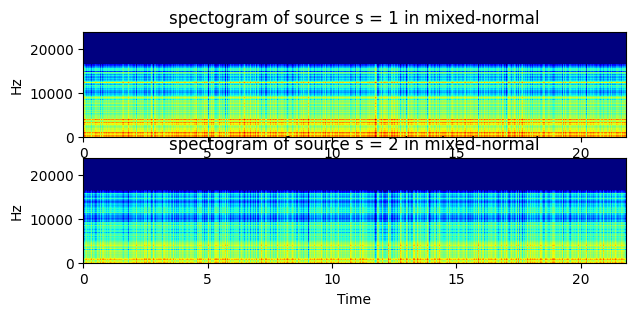

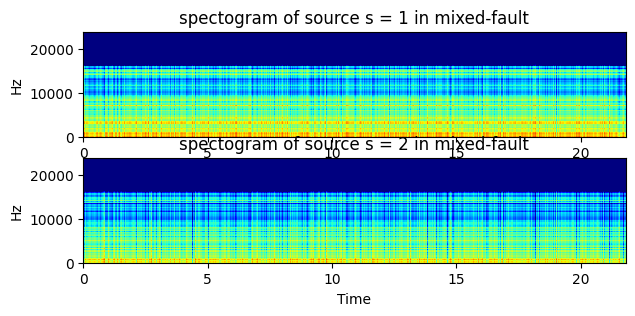

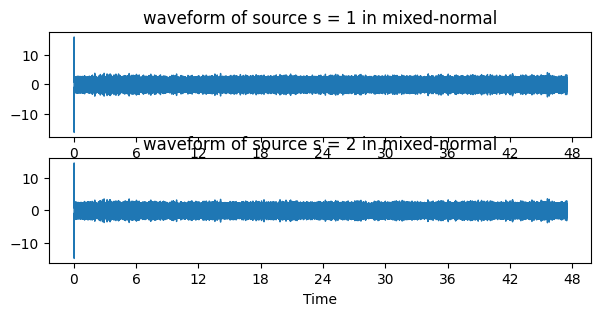

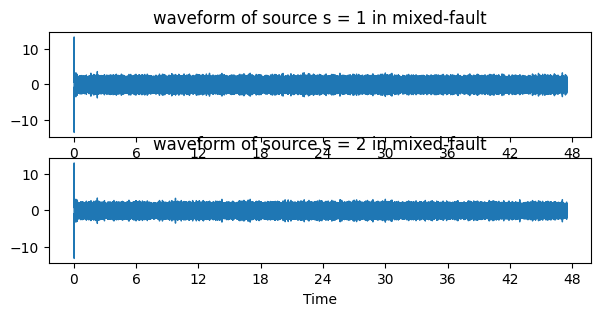

In [615]:
# spectogram 재구성-normal
fig, ax=plt.subplots(2,1, figsize=(7,3))
for i in range(2):
    ax[i].set_title(f"spectogram of source s = {i+1} in mixed-normal")
    librosa.display.specshow(spectogram_filtered_normal_list[i], x_axis='time', y_axis='hz', sr=sample_rate, hop_length=hop_length, cmap=plt.cm.jet, ax=ax[i])

# spectogram 재구성-fault
fig, ax=plt.subplots(2,1, figsize=(7,3))
for i in range(2):
    ax[i].set_title(f"spectogram of source s = {i+1} in mixed-fault")
    librosa.display.specshow(spectogram_filtered_fault_list[i], x_axis='time', y_axis='hz', sr=sample_rate, hop_length=hop_length, cmap=plt.cm.jet, ax=ax[i])
    
# waveform 재구성-normal
fig, ax=plt.subplots(2,1, figsize=(7,3))
for i in range(2):
    ax[i].set_title(f"waveform of source s = {i+1} in mixed-normal")
    librosa.display.waveshow(reconstruct_normal_list[i], ax=ax[i])

# waveform 재구성-fault
fig, ax=plt.subplots(2,1, figsize=(7,3))
for i in range(2):
    ax[i].set_title(f"waveform of source s = {i+1} in mixed-fault")
    librosa.display.waveshow(reconstruct_fault_list[i], ax=ax[i])

방법2) train & test

In [671]:
# audio load, 근데 m4a file은 load 실패
music, sr=librosa.load("./music48.mp3", sr=sample_rate) #default: mono=True
normal, sr=librosa.load("./펌프 정상.mp3", sr=sample_rate)
fault, sr=librosa.load("./펌프 inner race 불량.mp3", sr=sample_rate)

# audio 합성
min_len=min(len(music), len(normal), len(fault))
music=music[:min_len]
normal=normal[:min_len]
fault=fault[:min_len]
mixed_normal=normal+music_ratio*music
mixed_fault=fault+music_ratio*music

#STFT
#stft_normal=librosa.stft(mixed_normal, n_fft=2048, hop_length=int(2048/4))
stft_normal=librosa.stft(mixed_normal, n_fft=n_fft, hop_length=hop_length)
stft_fault=librosa.stft(mixed_fault, n_fft=n_fft, hop_length=hop_length)
stft_only_music=librosa.stft(music, n_fft=n_fft, hop_length=hop_length)
stft_only_normal=librosa.stft(normal, n_fft=n_fft, hop_length=hop_length)
stft_only_fault=librosa.stft(fault, n_fft=n_fft, hop_length=hop_length)

stft_only_music_magnitude=np.abs(stft_only_music)
stft_only_music_phase=np.angle(stft_only_music)
stft_only_normal_magnitude=np.abs(stft_only_normal)
stft_only_normal_phase=np.angle(stft_only_normal)
stft_only_fault_magnitude=np.abs(stft_only_fault)
stft_only_fault_phase=np.angle(stft_only_fault)
stft_normal_magnitude=np.abs(stft_normal)
stft_normal_phase=np.angle(stft_normal)
stft_fault_magnitude=np.abs(stft_fault)
stft_fault_phase=np.angle(stft_fault)

#NMF(TRAIN)
#latent_component: 2 -> source 2개  (basis 개수가 됨)
nmf_normal=NMF(stft_only_normal_magnitude, 1, 10, cost_function)
nmf_fault=NMF(stft_only_fault_magnitude, 1, 10, cost_function)
nmf_music=NMF(stft_only_music_magnitude, 1, 10, cost_function)

#NMF(TEST)
#latent_component: 2 -> source 2개  (basis 개수가 됨)
nmf_normal=NMF_test(stft_normal_magnitude, nmf_normal[1], nmf_music[1], 1, 10, cost_function)
nmf_fault=NMF_test(stft_fault_magnitude, nmf_fault[1], nmf_music[1], 1, 10, cost_function)

C:\Users\limuri\AppData\Local\Temp\ipykernel_19848\306025495.py:3: RuntimeWarning: divide by zero encountered in log
  cost=mat_V/np.dot(mat_B, mat_G)-np.log(mat_V/np.dot(mat_B, mat_G))-np.ones((mat_V.shape[0], mat_V.shape[1]))
C:\Users\limuri\AppData\Local\Temp\ipykernel_19848\306025495.py:3: RuntimeWarning: invalid value encountered in divide
  cost=mat_V/np.dot(mat_B, mat_G)-np.log(mat_V/np.dot(mat_B, mat_G))-np.ones((mat_V.shape[0], mat_V.shape[1]))


In [672]:
# spectogram 재구성-normal
spectogram_filtered_normal_list=[]
stft_filtered_normal1=np.dot(nmf_normal[1], nmf_normal[3])
stft_filtered_normal2=np.dot(nmf_normal[2], nmf_normal[4])
    
spectogram_filtered_normal1=librosa.amplitude_to_db(stft_filtered_normal1)
spectogram_filtered_normal2=librosa.amplitude_to_db(stft_filtered_normal2)
spectogram_filtered_normal_list.append(spectogram_filtered_normal1)
spectogram_filtered_normal_list.append(spectogram_filtered_normal2)

# spectogram 재구성-fault
spectogram_filtered_fault_list=[]
stft_filtered_fault1=np.dot(nmf_fault[1], nmf_fault[3])
stft_filtered_fault2=np.dot(nmf_fault[2], nmf_fault[4])
    
spectogram_filtered_fault1=librosa.amplitude_to_db(stft_filtered_fault1)
spectogram_filtered_fault2=librosa.amplitude_to_db(stft_filtered_fault2)
spectogram_filtered_fault_list.append(spectogram_filtered_fault1)
spectogram_filtered_fault_list.append(spectogram_filtered_fault2)

# waveform 재구성 - normal & fault    
reconstruct_normal_list=[]
for i in range(2):
    reconstruct_normal = spectogram_filtered_normal_list[i] * np.exp(1j*stft_normal_phase)
    new_sound = librosa.istft(reconstruct_normal, hop_length=hop_length, n_fft=n_fft)
    reconstruct_normal_list.append(new_sound)

reconstruct_fault_list=[]
for i in range(2):
    reconstruct_fault = spectogram_filtered_fault_list[i] * np.exp(1j*stft_fault_phase)
    new_sound = librosa.istft(reconstruct_fault, hop_length=hop_length, n_fft=n_fft)
    reconstruct_fault_list.append(new_sound)

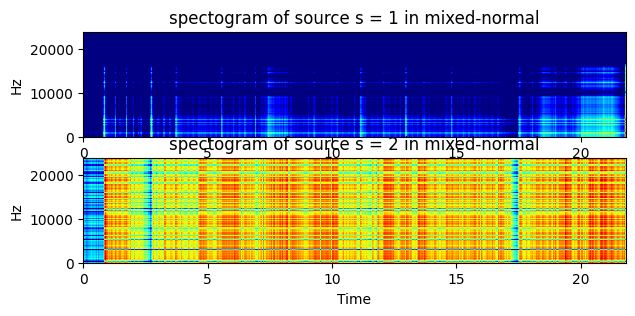

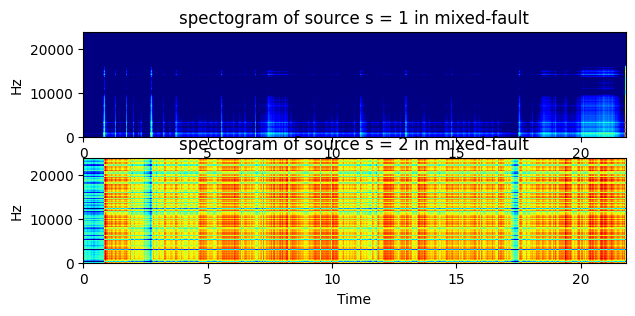

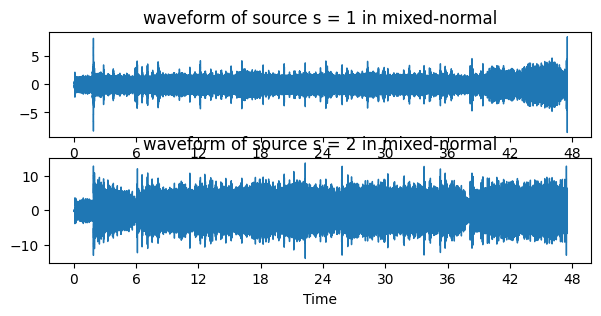

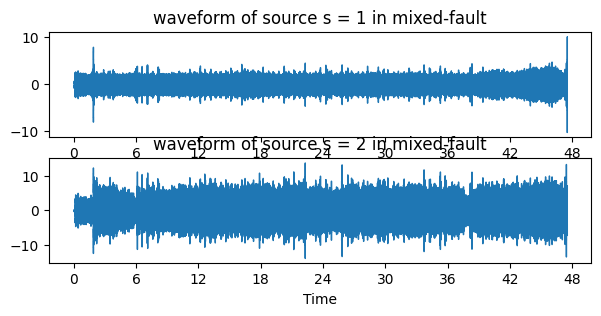

In [673]:
# spectogram 재구성-normal
fig, ax=plt.subplots(2,1, figsize=(7,3))
for i in range(2):
    ax[i].set_title(f"spectogram of source s = {i+1} in mixed-normal")
    librosa.display.specshow(spectogram_filtered_normal_list[i], x_axis='time', y_axis='hz', sr=sample_rate, hop_length=hop_length, cmap=plt.cm.jet, ax=ax[i])

# spectogram 재구성-fault
fig, ax=plt.subplots(2,1, figsize=(7,3))
for i in range(2):
    ax[i].set_title(f"spectogram of source s = {i+1} in mixed-fault")
    librosa.display.specshow(spectogram_filtered_fault_list[i], x_axis='time', y_axis='hz', sr=sample_rate, hop_length=hop_length, cmap=plt.cm.jet, ax=ax[i])
    
# waveform 재구성-normal
fig, ax=plt.subplots(2,1, figsize=(7,3))
for i in range(2):
    ax[i].set_title(f"waveform of source s = {i+1} in mixed-normal")
    librosa.display.waveshow(reconstruct_normal_list[i], ax=ax[i])

# waveform 재구성-fault
fig, ax=plt.subplots(2,1, figsize=(7,3))
for i in range(2):
    ax[i].set_title(f"waveform of source s = {i+1} in mixed-fault")
    librosa.display.waveshow(reconstruct_fault_list[i], ax=ax[i])

original spectogram and waveform of normal, fault, music

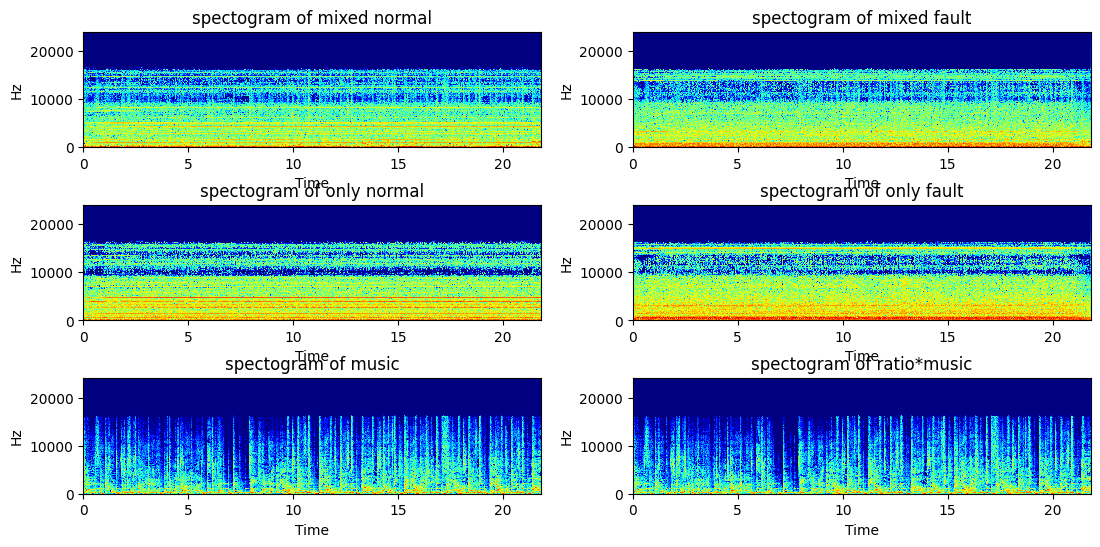

In [585]:
#stft plot

stft_only_normal=librosa.stft(normal, n_fft=2048, hop_length=hop_length)
stft_only_fault=librosa.stft(fault, n_fft=2048, hop_length=hop_length)
stft_music=librosa.stft(music, n_fft=2048, hop_length=hop_length)
stft_ratio_music=librosa.stft(music*music_ratio, n_fft=2048, hop_length=hop_length)

stft_only_normal_magnitude=np.abs(stft_only_normal)
stft_only_fault_magnitude=np.abs(stft_only_fault)
stft_music_magnitude=np.abs(stft_music)
stft_ratio_music_magnitude=np.abs(stft_ratio_music)

spectogram_normal=librosa.amplitude_to_db(stft_normal_magnitude)
spectogram_fault=librosa.amplitude_to_db(stft_fault_magnitude)
spectogram_only_normal=librosa.amplitude_to_db(stft_only_normal_magnitude)
spectogram_only_fault=librosa.amplitude_to_db(stft_only_fault_magnitude)
spectogram_music=librosa.amplitude_to_db(stft_music_magnitude)
spectogram_ratio_music=librosa.amplitude_to_db(stft_ratio_music_magnitude)

fig, ax=plt.subplots(3,2, figsize=(13,6))
fig.subplots_adjust(hspace=0.5)
ax[0,0].set_title('spectogram of mixed normal')
ax[0,1].set_title('spectogram of mixed fault')
ax[1,0].set_title('spectogram of only normal')
ax[1,1].set_title('spectogram of only fault')
ax[2,0].set_title('spectogram of music')
ax[2,1].set_title('spectogram of ratio*music')

librosa.display.specshow(spectogram_normal, x_axis='time', y_axis='hz', sr=sample_rate, hop_length=hop_length, cmap=plt.cm.jet, ax=ax[0,0])
librosa.display.specshow(spectogram_fault, x_axis='time', y_axis='hz', sr=sample_rate, hop_length=hop_length, cmap=plt.cm.jet, ax=ax[0,1])
librosa.display.specshow(spectogram_only_normal, x_axis='time', y_axis='hz', sr=sample_rate, hop_length=hop_length, cmap=plt.cm.jet, ax=ax[1,0])
librosa.display.specshow(spectogram_only_fault, x_axis='time', y_axis='hz', sr=sample_rate, hop_length=hop_length, cmap=plt.cm.jet, ax=ax[1,1])
librosa.display.specshow(spectogram_music, x_axis='time', y_axis='hz', sr=sample_rate, hop_length=hop_length, cmap=plt.cm.jet, ax=ax[2,0])
librosa.display.specshow(spectogram_ratio_music, x_axis='time', y_axis='hz', sr=sample_rate, hop_length=hop_length, cmap=plt.cm.jet, ax=ax[2,1])

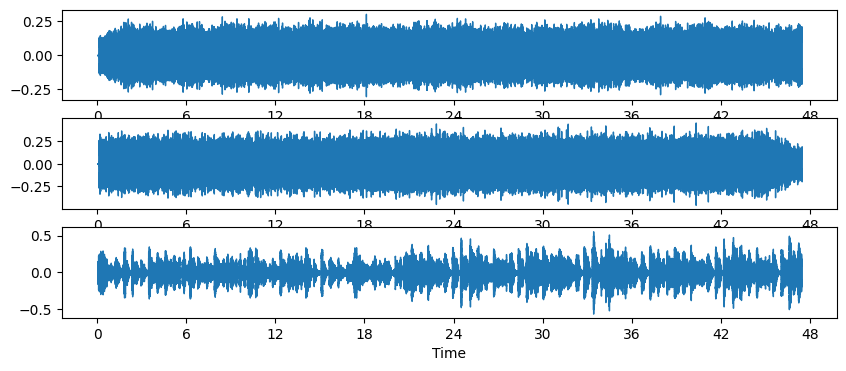

In [586]:
# original waveform
original_list=[normal, fault, music]
fig, ax=plt.subplots(3,1, figsize=(10,4))
for i in range(3):
    librosa.display.waveshow(original_list[i], ax=ax[i])

In [570]:
sd.play(music, samplerate=sample_rate)

In [675]:
sd.play(reconstruct_normal_list[0], samplerate=sample_rate)

# 들어보니까 reconstruct_normal_list[0] -> pump
# 들어보니까 reconstruct_normal_list[1] -> pump

In [677]:
sd.play(reconstruct_fault_list[1], samplerate=sample_rate)

# 들어보니까 reconstruct_fault_list[0] -> pump
# 들어보니까 reconstruct_fault_list[1] -> pump

In [678]:
sd.stop()